In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_Compress import generate_Y, compress
import pandas as pd
import itertools
import dask
from dask.distributed import Client, progress
import seaborn as sns
import time
import os.path

In [2]:
save_path = os.path.join('./result/')

In [3]:
# Work on previously saved data
params_df = pd.read_csv('result//param_Mon_May_23_21_46_49_2022.csv')
results_df = pd.read_csv('result//results_Mon_May_23_21_46_49_2022.csv')
total_df = pd.read_csv('result//total_Mon_May_23_21_47_07_2022.csv')

In [4]:
for index in params_df.columns:
    if (index == 'Unnamed: 0') :
        params_df.drop('Unnamed: 0', axis = 1, inplace=True)

for index in results_df.columns:
    if (index == 'Unnamed: 0') :
        results_df.drop('Unnamed: 0', axis = 1, inplace=True)
for index in total_df.columns:
    if (index == 'Unnamed: 0') :
        total_df.drop('Unnamed: 0', axis = 1, inplace=True)


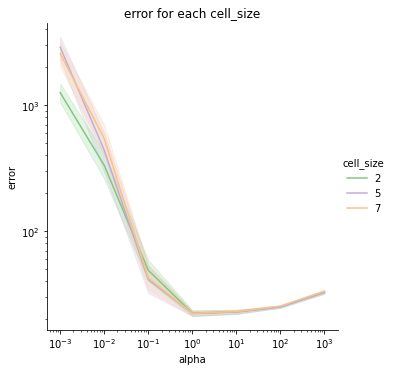

In [5]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', hue = 'cell_size')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each cell_size')
# fig.savefig(os.path.join(save_path, "alpha_error_per_size" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

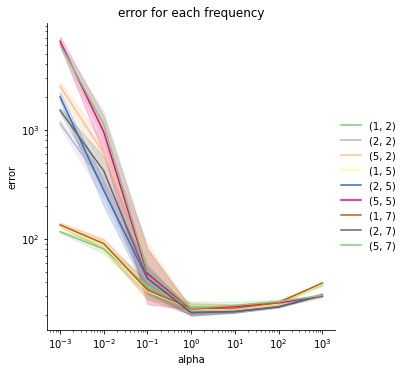

In [6]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', 
                  hue = params_df[['sparse_freq', 'cell_size']].apply(tuple, axis = 1))
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each frequency')
# fig.savefig(os.path.join(save_path, "alpha_error_per_freq" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

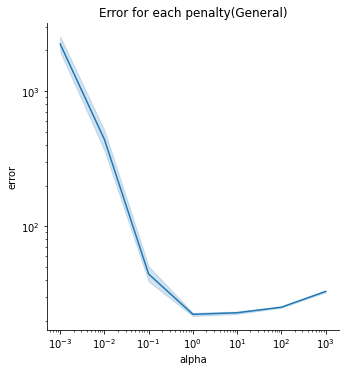

In [7]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='Error for each penalty(General)')
# fig.savefig(os.path.join(save_path, "alpha_error_general" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

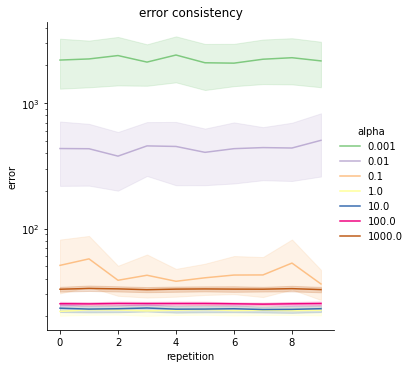

In [8]:
# To show how consistent randomly generated V1 weight would be for each rep. it should be about same for each repetition

fig = sns.relplot(data = params_df, x = 'repetition', y = 'error', kind='line', palette='Accent', hue = 'alpha')
fig.set(title='error consistency')
fig.set(yscale='log')
fig.savefig(os.path.join(save_path, "alpha_error_consistency" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

In [9]:
params_df.groupby(by=['num_cell', 'cell_size', 'sparse_freq', 'alpha']).mean().sort_values(by='error', ascending= True).drop('repetition', axis = 1).head(1)

,,,,error
num_cell,cell_size,sparse_freq,alpha,
500,7,2,0.01,12.709595


In [10]:
params_df.groupby(by=['num_cell', 'cell_size', 'sparse_freq', 'alpha']).mean().drop('repetition', axis = 1)

error
num_cell cell_size sparse_freq alpha               
100      2         1           0.001     112.002055
                               0.010      97.495488
                               0.100      55.324570
                               1.000      32.257178
                               10.000     31.780242
...                                             ...
500      7         5           0.100      21.353924
                               1.000      22.794254
                               10.000     24.352661
                               100.000    26.299258
                               1000.000   30.004754

[189 rows x 1 columns]

In [11]:
compress_param_df = pd.read_csv('result//Compress_param_Wed_May_25_14_52_32_2022.csv')

seaborn.axisgrid.FacetGrid

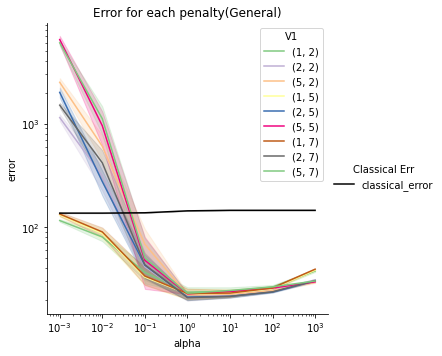

In [105]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', 
                  hue = params_df[['sparse_freq', 'cell_size']].apply(tuple, axis = 1), legend = False)

fig.set(title='Error for each penalty(General)')
fig.map(sns.lineplot, x = 'alpha', y = 'error', data = compress_param_df, 
        label= 'classical_error', color = 'black', legend = True).add_legend(title='Classical Err', loc = 'right')
fig.set(yscale='log')
fig.set(xscale='log')
plt.legend(title = 'V1', labels =['(1, 2)', '(2, 2)', '(5, 2)', '(1, 5)', '(2, 5)', '(5, 5)', '(1, 7)', '(2, 7)', '(5, 7)'])
# plt.legend(title = 'Classical', label = ['classic'])

# compress_fig = sns.relplot(data = compress_param_df, x = 'alpha', y = 'error', kind= 'line')
# compress_fig.set(yscale='log')
# compress_fig.set(xscale='log')
type(fig)

In [32]:
temp_err = params_df.groupby(['num_cell', 'sparse_freq', 'cell_size', 'alpha']).agg({'error':'mean'})

## Error Vs Num_Cell Graph

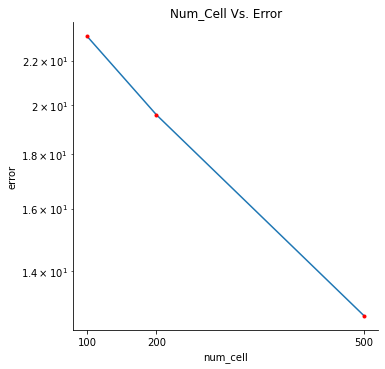

In [79]:
mean_err = params_df.groupby(['num_cell', 'sparse_freq', 'cell_size', 'alpha'], as_index = False).agg({'error':'mean'})
line_data = mean_err.groupby(['num_cell'], as_index = False).agg({'error':'min'})
fig = sns.relplot(x = line_data['num_cell'], y = line_data['error'], kind='line')
plt.title("Num_Cell Vs. Error")
plt.xticks(line_data['num_cell'])
fig.set(yscale = 'log')
plt.plot(line_data['num_cell'], line_data['error'], 'r.')

In [57]:
line_data['num_cell'].value_counts().sum()

3

In [86]:
min_mean_err_df = pd.DataFrame()
for i in mean_err['num_cell'].unique():
    temp = mean_err.loc[mean_err['num_cell'] == i]
    #hyperparameter for each number of cell
    ## Grabbing values by each values
    min_mean_err_df = min_mean_err_df.append(temp.loc[temp['error'] == temp['error'].min()])
    
# Merge two data to extract
min_mean_err_df = min_mean_err_df.rename(columns={'error' : 'mean_err'})
merged_df = pd.merge(params_df, min_mean_err_df, on = ['num_cell', 'sparse_freq', 'cell_size', 'alpha'], how = 'left')
plotting_data = merged_df.loc[merged_df['mean_err'].notnull()]

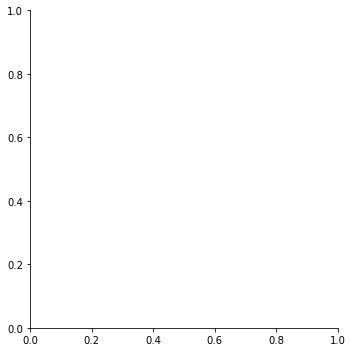

In [104]:
fig = sns.relplot()

In [36]:
params_df[(min_err_df.iloc[:, 0:4].head(1).values == params_df.iloc[:, 1:5].values).all(axis=1)]

,repetition,num_cell,cell_size,sparse_freq,alpha,error
86,0,100,5,5,1.0,23.323652
275,1,100,5,5,1.0,23.080329
464,2,100,5,5,1.0,22.865730
653,3,100,5,5,1.0,23.166681
842,4,100,5,5,1.0,22.958887
1031,5,100,5,5,1.0,23.147109
1220,6,100,5,5,1.0,23.117333
1409,7,100,5,5,1.0,22.862780
1598,8,100,5,5,1.0,23.043382
1787,9,100,5,5,1.0,24.205200


In [19]:
num_cell_error_df = pd.DataFrame()
min_err_df = min_err_df.reset_index(drop = True)
for i in range(len(min_err_df)):
    print(i)
    num_cell_error_df = num_cell_error_df.append(params_df[
        (min_err_df.iloc[:, 0:4].iloc[i].values == params_df.iloc[:, 1:5].values).all(axis=1)])
    

0
1
2


In [20]:
params_df[['num_cell', 'cell_size', 'sparse_freq', 'alpha']].values

array([[1.e+02, 2.e+00, 1.e+00, 1.e-03],
       [1.e+02, 2.e+00, 2.e+00, 1.e-03],
       [1.e+02, 2.e+00, 5.e+00, 1.e-03],
       ...,
       [5.e+02, 7.e+00, 1.e+00, 1.e+03],
       [5.e+02, 7.e+00, 2.e+00, 1.e+03],
       [5.e+02, 7.e+00, 5.e+00, 1.e+03]])

In [38]:
params_df.iloc[params_df[['num_cell', 'cell_size', 'sparse_freq', 'alpha']].values == min_err_df.iloc[:, 0:4].iloc[0].values]

,repetition,num_cell,cell_size,sparse_freq,alpha,error
0,0,100,2,1,0.001,118.552402
1,0,100,2,2,0.001,1517.257701
2,0,100,2,5,0.001,2642.888029
2,0,100,2,5,0.001,2642.888029
3,0,100,5,1,0.001,122.698407
...,...,...,...,...,...,...
1884,9,500,5,1,1000.000,36.726366
1885,9,500,5,2,1000.000,28.332152
1886,9,500,5,5,1000.000,29.203209
1886,9,500,5,5,1000.000,29.203209


In [22]:
min_err_df.reset_index(drop = True).iloc[:, 0:4].iloc[1].values

array([200.,   2.,   7.,   1.])

In [23]:
params_df[(min_err_df.iloc[:, 0:4].iloc[2].values == params_df.iloc[:, 1:5].values).all(axis=1)]

,repetition,num_cell,cell_size,sparse_freq,alpha,error


In [24]:
num_cell_error_df

,repetition,num_cell,cell_size,sparse_freq,alpha,error
86,0,100,5,5,1.0,23.323652
275,1,100,5,5,1.0,23.080329
464,2,100,5,5,1.0,22.865730
653,3,100,5,5,1.0,23.166681
842,4,100,5,5,1.0,22.958887
1031,5,100,5,5,1.0,23.147109
1220,6,100,5,5,1.0,23.117333
1409,7,100,5,5,1.0,22.862780
1598,8,100,5,5,1.0,23.043382
1787,9,100,5,5,1.0,24.205200


In [25]:
# params_df[(min_err_df.iloc[:, 0:4].loc[1].values == params_df.iloc[:, 1:5].values).all(axis=1)]
params_df.iloc[:, 1:5]

,num_cell,cell_size,sparse_freq,alpha
0,100,2,1,0.001
1,100,2,2,0.001
2,100,2,5,0.001
3,100,5,1,0.001
4,100,5,2,0.001
...,...,...,...,...
1885,500,5,2,1000.000
1886,500,5,5,1000.000
1887,500,7,1,1000.000
1888,500,7,2,1000.000


In [26]:
min_err_df.iloc[:, 0:4].iloc[1].values

array([200.,   2.,   7.,   1.])

In [27]:
params_df.iloc[:, 1:5].values

array([[1.e+02, 2.e+00, 1.e+00, 1.e-03],
       [1.e+02, 2.e+00, 2.e+00, 1.e-03],
       [1.e+02, 2.e+00, 5.e+00, 1.e-03],
       ...,
       [5.e+02, 7.e+00, 1.e+00, 1.e+03],
       [5.e+02, 7.e+00, 2.e+00, 1.e+03],
       [5.e+02, 7.e+00, 5.e+00, 1.e+03]])

In [28]:
np.unique((min_err_df.iloc[:, 0:4].iloc[1].values == params_df.iloc[:, 1:5].values).all(axis=1))

array([False])

In [31]:
# params_df[params_df["num_cell"] == 200.] & params_df[params_df["cell_size"] == 2.]

In [30]:
min_err_df.iloc[:, 0:4].iloc[1].values

array([200.,   2.,   7.,   1.])